# CallMeMaybe: Servicio de telefonía virtual

<a id=indice></a>
# Tabla de Contenido

[1 Descripción del Proyecto](#descripcion)

[2 Lectura y preparación de datos](#preparacion_data)

[3 Analisis exploratorio de datos](#analisis_data)

[4 Identificación de operadores ineficaces](#identificador_operadores)

[5 Prueba de hipótesis estadística](#prueba_hipotesis)

[6 Conclusiones y recomendaciones](#conclusiones)

[7 Presentación](#presentacion)

<a id="descripcion"></a>
## Descripción del Proyecto

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

[Volver a la Tabla de Contenido](#indice)

<a id="preparacion_data"></a>
## Lectura y Preparación de datos

### Descripción de datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

### Importación de librerías

In [1]:
import pandas as pd

import datetime as dt
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

### Carga de datos

In [2]:
# Especificamos la ruta donde se encuentran los datasets para el desarrollo del proyecto
path = 'C:/Users/Usuario/Documents/Pam/Bootcamp DA - TRIPLETEN/Sprint 14 - Proyecto Final/01 Empresa Telecomunicaciones - Descomposicion y Dashboard/datasets'

In [3]:
# Cargamos los dataframes
clients = pd.read_csv(path+'/telecom_clients_us.csv')
calls = pd.read_csv(path+'/telecom_dataset_us.csv')

In [4]:
# Validación de carga de datos correcta
clients.head(5)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [5]:
# Validación de carga de datos correcta
calls.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


### Revisión de datos (duplicados, nulos y tipo de datos)

#### Tabla `clients`

In [6]:
# Visualizamos información de la tabla
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


##### Validación de tipo de datos

In [7]:
# Revisamos si los valores de la siguiente columna podría ser cargada como tipo de dato "category"
clients['tariff_plan'].unique()

array(['A', 'C', 'B'], dtype=object)

In [8]:
# Cambiamos los tipos de datos de las columnas "tariff_plan" y "date_start"
clients['tariff_plan'] = clients['tariff_plan'].astype('category')
clients['date_start'] = pd.to_datetime(clients['date_start'])

clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    category      
 2   date_start   732 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 12.4 KB


##### Validación de valores duplicados

In [9]:
print('Valores duplicados:', clients.duplicated().sum())

Valores duplicados: 0


##### Validación de valores nulos

In [10]:
print('Valores nulos:', clients.isna().sum())

Valores nulos: user_id        0
tariff_plan    0
date_start     0
dtype: int64


De la revisión del dataframe "clients" se conluye lo siguiente:
- Se optó por modificar el tipo de dato de los campos:
    - `tariff_plan`: de object a category
    - `date_start`: de object a datetime 
- No se encontraron valores duplicados.
- No se encontraron valores nulos.

#### Tabla `calls`

In [11]:
# Visualizamos información de la tabla
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


##### Validación de tipo de datos

In [12]:
# Revisamos si los valores de la siguiente columna podría ser cargada como tipo de dato "category"
print(calls['direction'].unique())
print(calls['internal'].unique())
print(calls['is_missed_call'].unique())

['in' 'out']
[False True nan]
[ True False]


In [13]:
# Modificamos el tipo de datos de los campos "direction", "internal"
calls['direction'] = calls['direction'].astype('category')
calls['internal'] = calls['internal'].astype('bool')

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   user_id              53902 non-null  int64   
 1   date                 53902 non-null  object  
 2   direction            53902 non-null  category
 3   internal             53902 non-null  bool    
 4   operator_id          45730 non-null  float64 
 5   is_missed_call       53902 non-null  bool    
 6   calls_count          53902 non-null  int64   
 7   call_duration        53902 non-null  int64   
 8   total_call_duration  53902 non-null  int64   
dtypes: bool(2), category(1), float64(1), int64(4), object(1)
memory usage: 2.6+ MB


In [14]:
# Agregamos un campo de fecha que se encuentre en la zona horaria nuestra
calls['date_utc'] = pd.to_datetime(calls['date']).dt.tz_localize(None)

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   date                 53902 non-null  object        
 2   direction            53902 non-null  category      
 3   internal             53902 non-null  bool          
 4   operator_id          45730 non-null  float64       
 5   is_missed_call       53902 non-null  bool          
 6   calls_count          53902 non-null  int64         
 7   call_duration        53902 non-null  int64         
 8   total_call_duration  53902 non-null  int64         
 9   date_utc             53902 non-null  datetime64[ns]
dtypes: bool(2), category(1), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.0+ MB


##### Validación de valores duplicados

In [15]:
print('Valores Duplicados:', calls.duplicated().sum())

Valores Duplicados: 4900


In [16]:
# Eliminamos valores duplicados
calls.drop_duplicates(inplace=True)
calls.reset_index(inplace=True, drop=True)
print('Valores Duplicados:', calls.duplicated().sum())

Valores Duplicados: 0


In [17]:
# Validamos la información de la tabla "calls"
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  object        
 2   direction            49002 non-null  category      
 3   internal             49002 non-null  bool          
 4   operator_id          41546 non-null  float64       
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
 9   date_utc             49002 non-null  datetime64[ns]
dtypes: bool(2), category(1), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.8+ MB


##### Validación de valores nulos

In [18]:
print('Valores nulos:', calls.isna().sum())

Valores nulos: user_id                   0
date                      0
direction                 0
internal                  0
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
date_utc                  0
dtype: int64


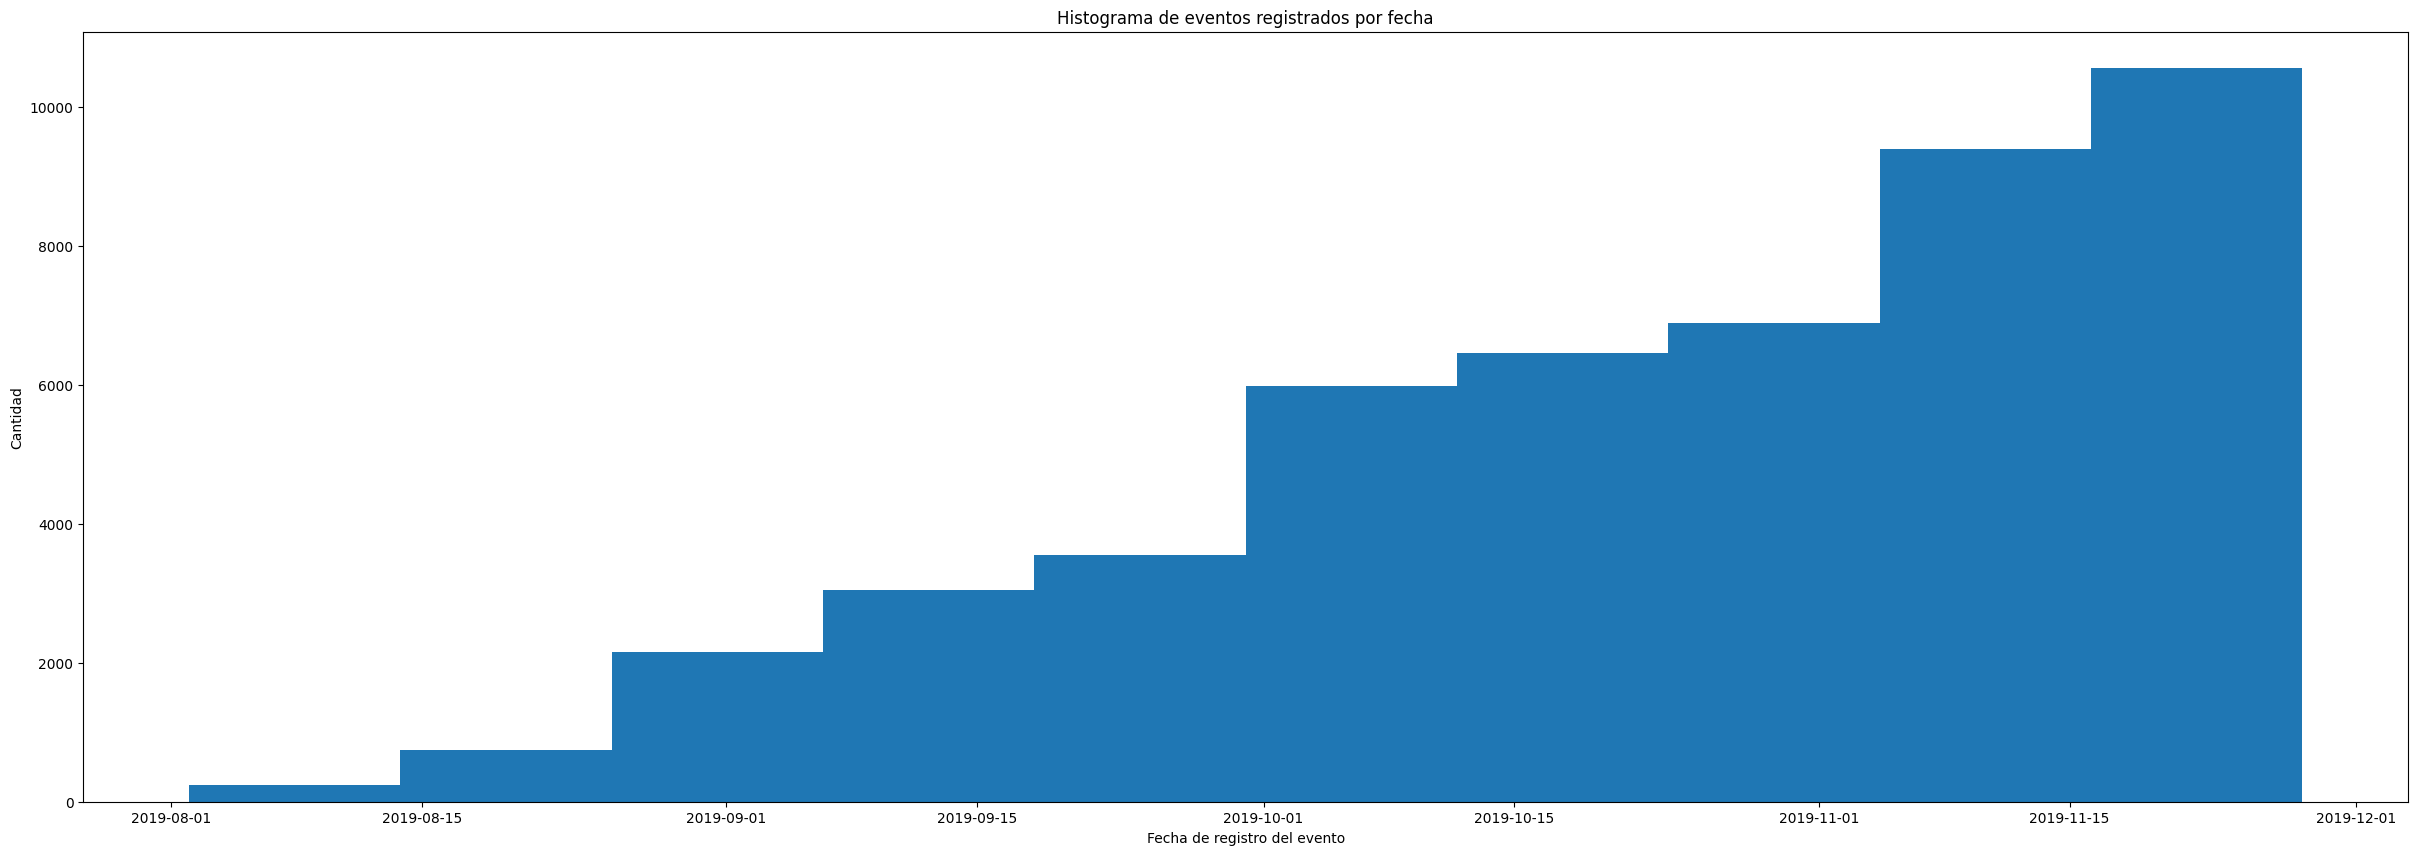

In [19]:
# Validamos la distribución de los registros antes de eliminar registros con valores nulos.
fig, test = plt.subplots()

plt.hist(calls['date_utc'])

test.set_title('Histograma de eventos registrados por fecha')
test.set_ylabel('Cantidad')
test.set_xlabel('Fecha de registro del evento')

fig.set_figheight(10)
fig.set_figwidth(30)

Dado que el objetivo del proyecto busca identificar los operadores ineficientes, podemos excluir a los registros de llamadas que no cuentan con el dato `operador_id` que es lo que nos permitirá brindar un análisis completo.

In [20]:
# Eliminamos registros con valores nulos en el campo "operator_id"
calls.dropna(subset=['operator_id'], inplace=True)
calls.reset_index(inplace=True, drop=True)

print(calls.isna().sum())

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
date_utc               0
dtype: int64


In [21]:
# Modificamos el tipo de datos de los campos "operation_id"
calls['operator_id'] = calls['operator_id'].astype('int')

In [22]:
# Validamos la información de la tabla "calls"
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41546 entries, 0 to 41545
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41546 non-null  int64         
 1   date                 41546 non-null  object        
 2   direction            41546 non-null  category      
 3   internal             41546 non-null  bool          
 4   operator_id          41546 non-null  int64         
 5   is_missed_call       41546 non-null  bool          
 6   calls_count          41546 non-null  int64         
 7   call_duration        41546 non-null  int64         
 8   total_call_duration  41546 non-null  int64         
 9   date_utc             41546 non-null  datetime64[ns]
dtypes: bool(2), category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 2.3+ MB


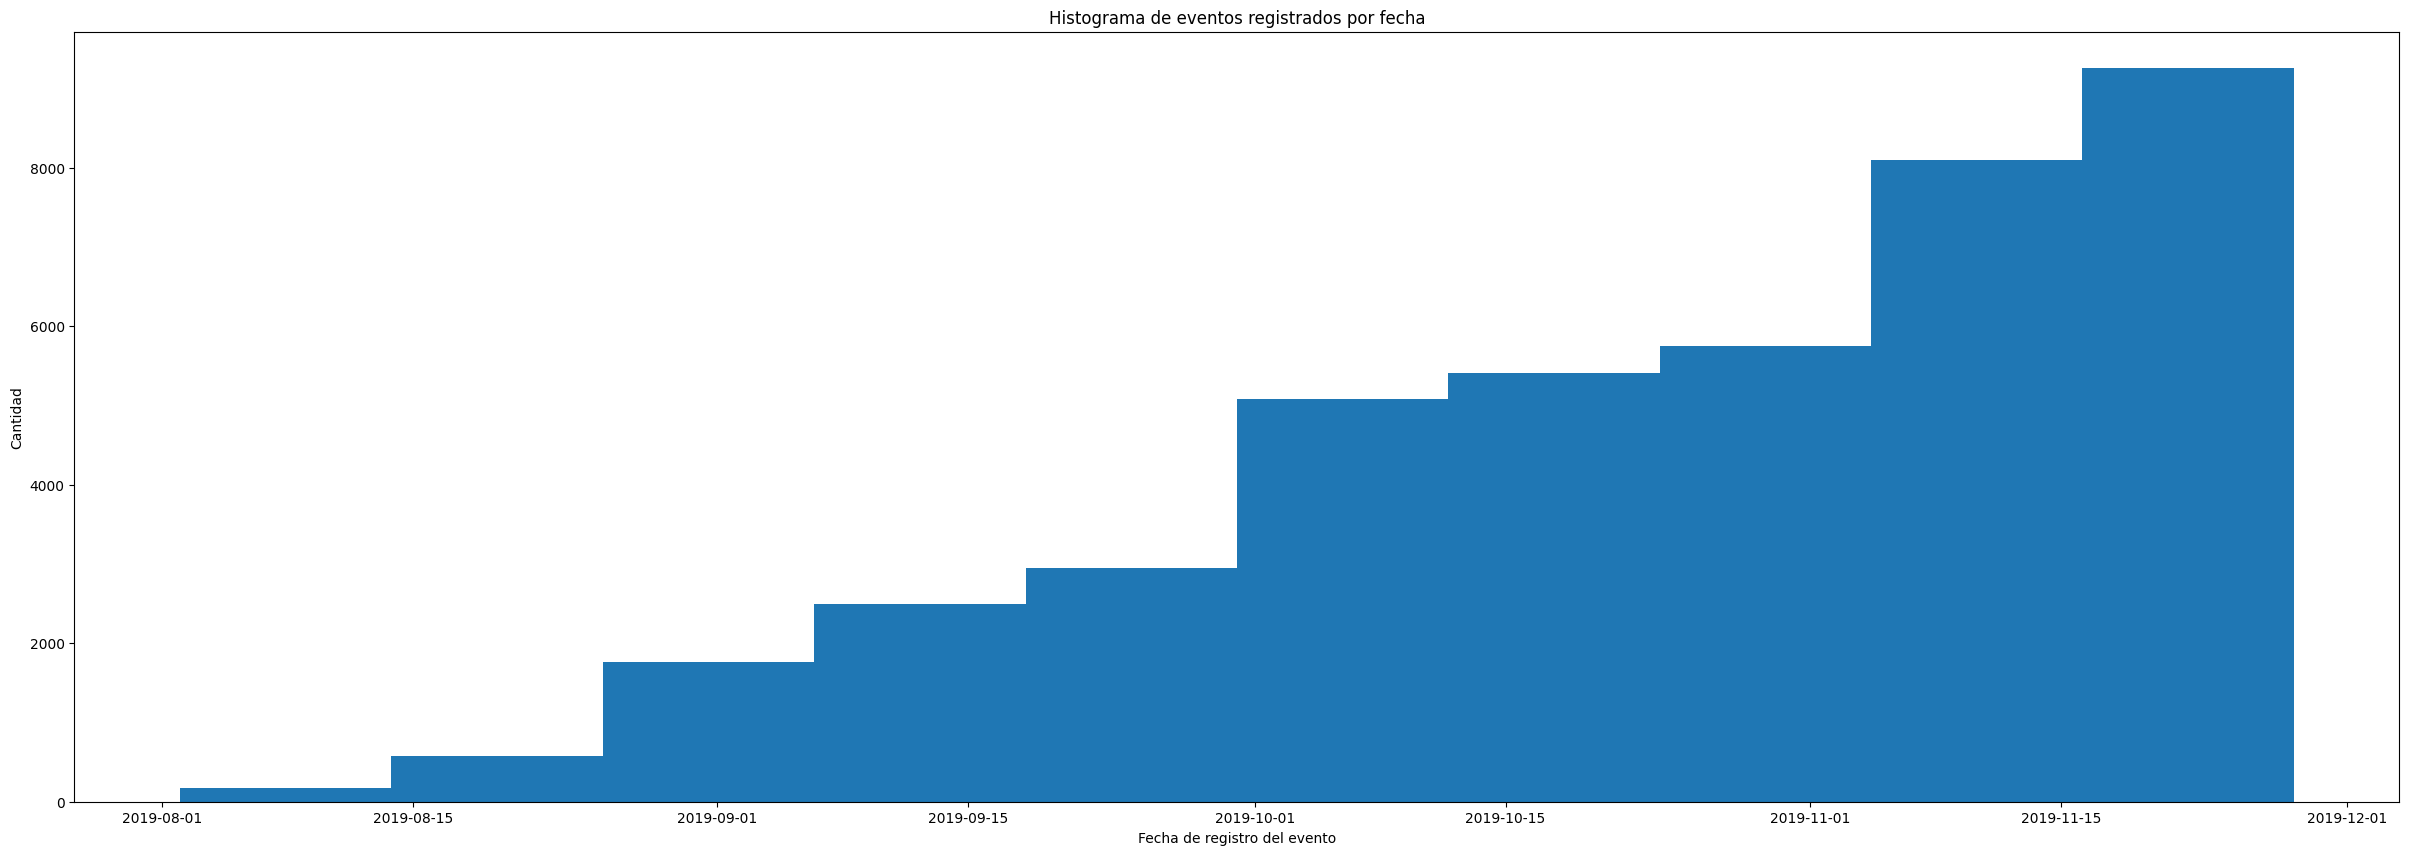

In [23]:
# Validamos si al eliminar los registros nos quedamos con un periodo de fechas completo
fig, test = plt.subplots()

plt.hist(calls['date_utc'])

test.set_title('Histograma de eventos registrados por fecha')
test.set_ylabel('Cantidad')
test.set_xlabel('Fecha de registro del evento')

fig.set_figheight(10)
fig.set_figwidth(30)

De la revisión del dataframe "calls" se conluye lo siguiente:
- Se optó por modificar el tipo de dato de los campos:
    - `direction`: de object a category
    - `internal`: de object a bool
- Se creó un campo `date_utc` con el tipo de dato "datetime" para poder realizar el análisis de datos para el desarrollo del proyecto.
- Se encontraron 4,900 registros duplicados (9% del total de registros) los cuales fueron eliminados para el desarrollo del proyecto.
- Se encontraron 7,456 registros con valores nulos en el campo `operator_id`, y se consideró eliminarlos para el desarrollo del proyecto debido a que es un campo necesario para el análisis.

[Volver a la Tabla de Contenido](#indice)

<a id="analisis_data"></a>
## Análisis exploratorio de datos

### Validación de valores atípicos

#### Llamadas diferenciadas por tipo de dirección de la llamada: "entrada" o "salida"

<AxesSubplot:xlabel='direction', ylabel='calls_count'>

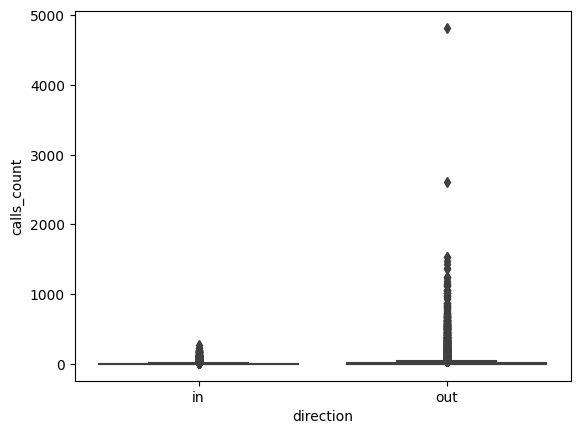

In [24]:
# llamadas diferenciadas por tipo de dirección: "entrada" o "salida"
sns.boxplot(data=calls, x='direction', y= calls['calls_count'])

In [25]:
calls[(calls['direction']=='out') & (calls['calls_count']>2000)]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_utc
31163,167827,2019-10-31 00:00:00+03:00,out,False,929428,True,2614,0,45312,2019-10-31
31207,167827,2019-11-11 00:00:00+03:00,out,False,929428,True,4817,0,5529,2019-11-11


In [26]:
# Eliminamos los dos registros atípicos
calls.drop(calls[(calls['direction']=='out') & (calls['calls_count']>2000)].index, inplace=True)
calls.reset_index(drop=True)

calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41544 entries, 0 to 41545
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41544 non-null  int64         
 1   date                 41544 non-null  object        
 2   direction            41544 non-null  category      
 3   internal             41544 non-null  bool          
 4   operator_id          41544 non-null  int64         
 5   is_missed_call       41544 non-null  bool          
 6   calls_count          41544 non-null  int64         
 7   call_duration        41544 non-null  int64         
 8   total_call_duration  41544 non-null  int64         
 9   date_utc             41544 non-null  datetime64[ns]
dtypes: bool(2), category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 2.7+ MB


Se encontraron 2 registros con valores atípicos muy marcados por lo que se decidió excluirlos del análisis. Además se observa que los valores atípicos estan más presente en las llamadas de salida.

#### Llamadas diferenciadas por tipo de llamada: "interna" o "externa"

<AxesSubplot:xlabel='internal', ylabel='calls_count'>

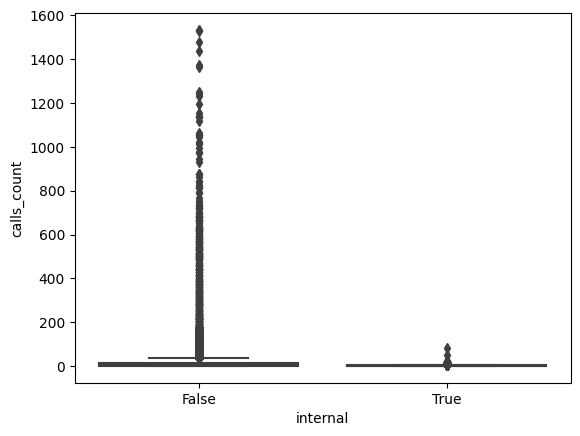

In [27]:
# Llamadas diferenciadas por tipo de llamada: "interna" o "externa"
sns.boxplot(data=calls, x='internal', y= calls['calls_count'])

Se observa que hay mayor cantidad de valores atípicos en la salidas externas; sin embargo, se optó por no eliminarlos del análisis.

#### Llamadas diferenciadas diferenciado por "contestada" o "pérdida"

<AxesSubplot:xlabel='is_missed_call', ylabel='calls_count'>

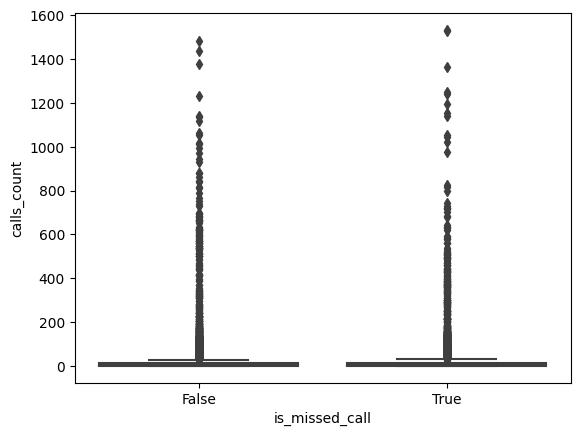

In [28]:
# llamadas diferenciadas diferenciado por "contestada" o "pérdida"
sns.boxplot(data=calls, x='is_missed_call', y= calls['calls_count'])

Se observa que los valores atípicos estan presentes tanto en las llamadas pérdidas como contestadas. Se optó por no excluir ningún registro.

### Distribución de clientes

In [29]:
# Cantidad de clientes
clients['user_id'].nunique()

732

In [30]:
# Cantidad de clientes por fecha
clients_x_date = clients.groupby('date_start')['user_id'].nunique().reset_index()
clients_x_date.columns = ['date_start', 'users_number'] 

Text(0.5, 0, 'Fecha de registro del usuario')

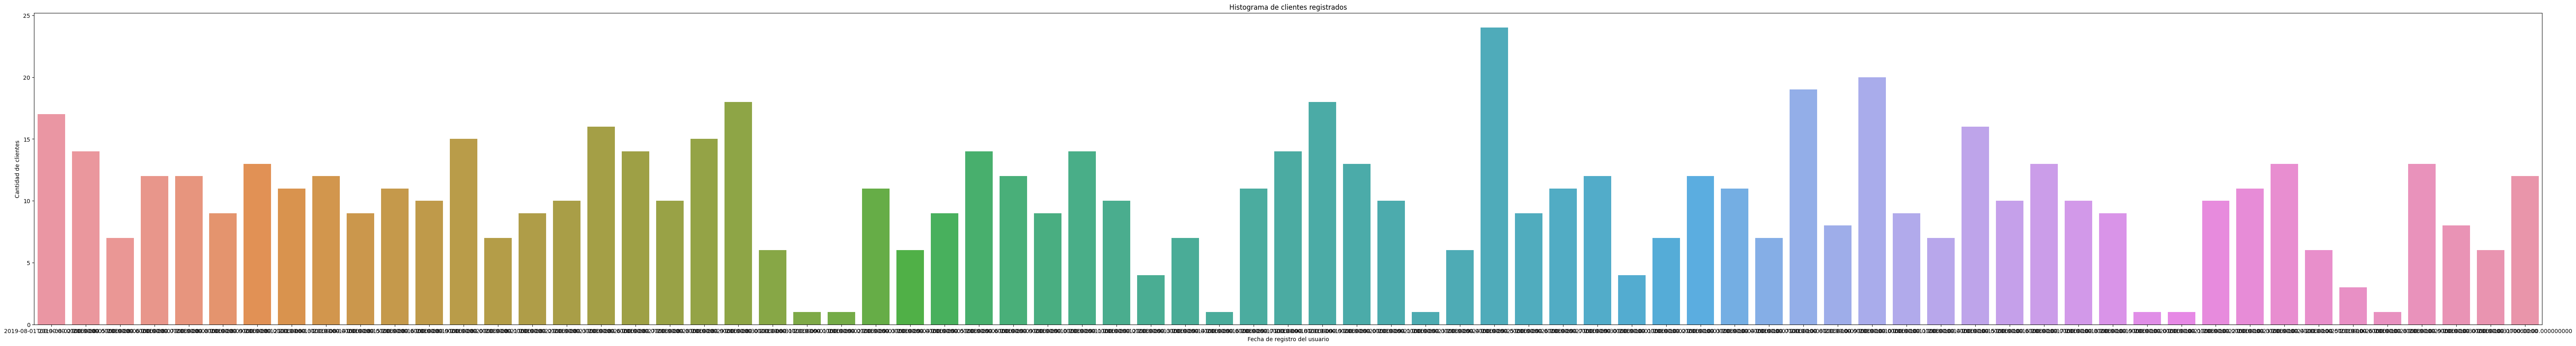

In [31]:
# Graficamos la distribución de clientes
fig, test = plt.subplots(figsize = (80, 10))
sns.barplot(data=clients_x_date, x='date_start', y='users_number')
test.set_title('Histograma de clientes registrados')
test.set_ylabel('Cantidad de clientes')
test.set_xlabel('Fecha de registro del usuario')

De lo revisado se observa lo siguiente:
* La muestra indica que se tienen 732 clientes.
* La cantidad de clientes desde el 01/08/2019 hasta el 31/10/2019 ha sido constante, salvo algunos días.

### Distribución de operadores

In [32]:
# Cantidad de operadores que atienden llamadas
calls['operator_id'].nunique()

1092

In [33]:
# Cantidad promedio de operadores atienden a cada cliente
operators_x_client = calls.groupby('user_id')['operator_id'].nunique().reset_index()
operators_x_client.columns = ['user_id', 'operators_number']
operators_x_client['operators_number'].mean()

3.7655172413793103

In [34]:
# Cantidad promedio de usuarios que atiende cada operador
calls.groupby('operator_id')['user_id'].nunique().mean()

1.0

<AxesSubplot:>

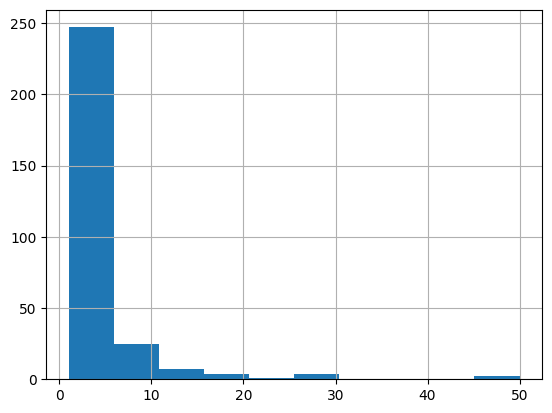

In [35]:
# Graficamos la distribución de operadores que atiende a cada cliente
operators_x_client['operators_number'].hist()

De lo revisado se observa lo siguiente:
* La muestra indica que se tienen 1,092 operadores que atienden a los 732 clientes.
* El número de operadores en promedio que atiende a cada usuario es 4.
* Un operador solo atiende a un usuario.
* Los usuarios tienen entre 1 y 10 operadores atendiendo sus llamadas; sin embargo, hay algunos usuarios que pueden tener hasta 50 operadores.

###  Distribución del tarifario

In [36]:
# Armamos una dataframe donde podamos ver por cliente: cantidad de operadores y tarifario

registers = clients.merge(calls, on='user_id', how='inner')

registers.groupby('tariff_plan').agg({'user_id':'nunique', 'operator_id':'nunique', 'calls_count':'sum', 'call_duration': 'sum'})

,user_id,operator_id,calls_count,call_duration
tariff_plan,,,,
A,32,310,380271,21336066
B,101,395,138711,10372319
C,157,387,175732,10243485


De lo revisado se observa lo siguiente:
* La muestra indica que se tienen 3 tipos de tarifa: A, B, C. Donde asumiremos que el plan más caro es A, seguido de B y finalmente C (plan más barato).
* La mayor cantidad de usuarios se encuentra entre el plan B y C; y unos pocos en el plan A.
* El número de operadores por tipo de plan asignado es equitativo.
* El número de llamadas realizadas por tipo de tarifa es mayor en el plan A y eso debe explicar porque la duración total de las llamadas en el plan A también es el más alto.

### Distribución de llamadas

In [37]:
# Cantidad de llamadas y operadores por fecha
calls_x_date = calls.groupby('date_utc').agg({'calls_count':'sum', 'operator_id':'nunique'}).reset_index()
calls_x_date.columns = ['date', 'calls_count', 'operators_count']
calls_x_date.head(5)

,date,calls_count,operators_count
0,2019-08-02,19,3
1,2019-08-03,27,2
2,2019-08-04,4,2
3,2019-08-05,183,4
4,2019-08-06,184,7


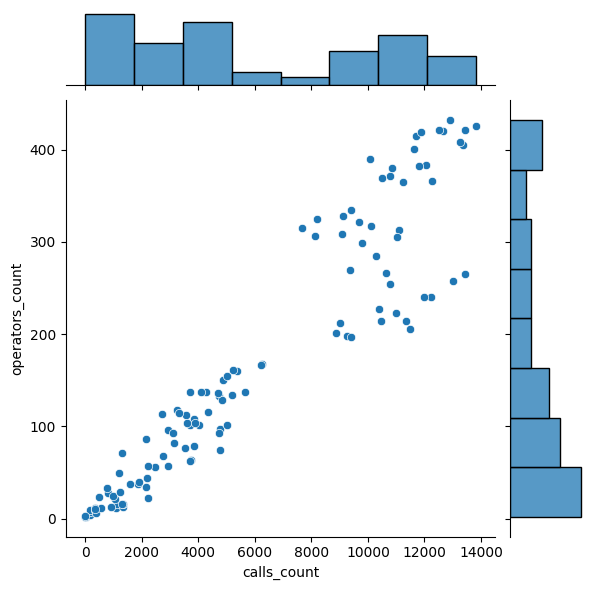

In [38]:
# Validamos si existe correlación entre la cantidad de llamadas y la cantidad de operadores por fecha
sns.jointplot(data=calls_x_date, x='calls_count', y='operators_count')

Text(0.5, 0, 'Fecha de registro de llamada')

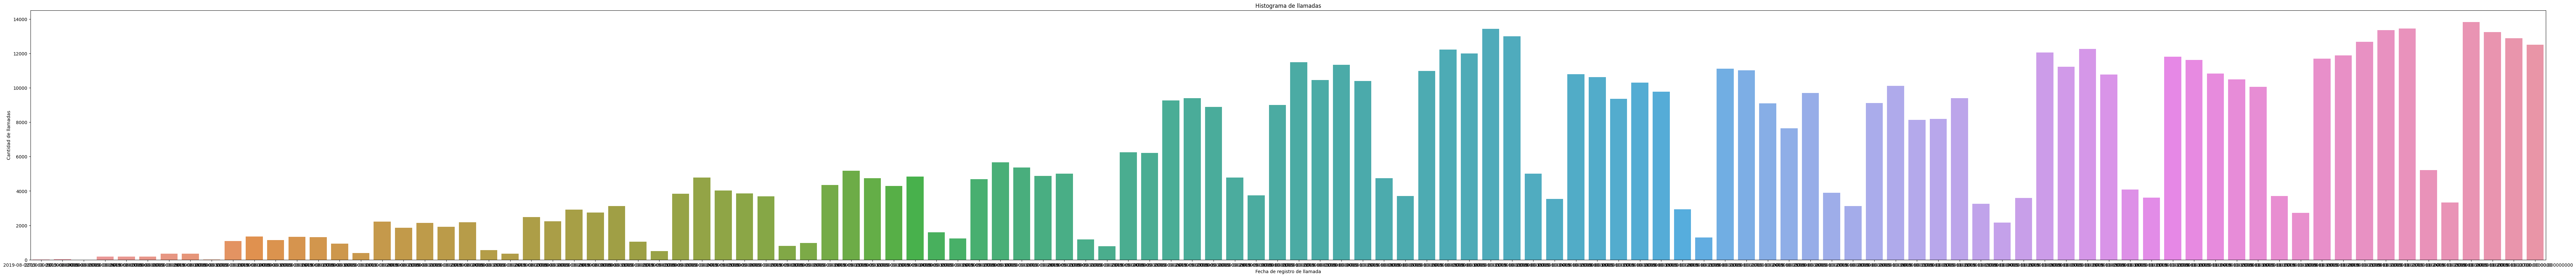

In [39]:
# Graficamos la distribución de llamadas
fig, test = plt.subplots(figsize = (100, 10))
sns.barplot(data=calls_x_date, x='date', y='calls_count')
test.set_title('Histograma de llamadas')
test.set_ylabel('Cantidad de llamadas')
test.set_xlabel('Fecha de registro de llamada')

De lo revisado se observa lo siguiente:
* La muestra indica que sí existe correlación directa, a mayor cantidad de operadores mayor cantidad de llamadas.
* La muestra indica que la cantidad de llamadas fueron incrementando constantemente, llegando a ser estables a partir de mediados de setiembre.

### Llamadas por tipo de procedencia

In [40]:
# Duracion de llamadas diferenciado por tipo de llamada: entrada o salida
calls.groupby('direction').agg({'calls_count':'sum', 'call_duration':'sum', 'total_call_duration':'sum'})

,calls_count,call_duration,total_call_duration
direction,,,
in,93802,9524011,10757296
out,600912,32427859,44098758


In [41]:
# Duracion de llamadas diferenciado por tipo: externo o interno
calls.groupby('internal').agg({'calls_count':'sum', 'call_duration':'sum', 'total_call_duration':'sum'})

,calls_count,call_duration,total_call_duration
internal,,,
False,680989,41363119,54154500
True,13725,588751,701554


In [42]:
# Duracion de llamadas por tipo de llamada: perdida
calls.groupby('is_missed_call').agg({'calls_count':'sum', 'call_duration':'sum', 'total_call_duration':'sum'})

,calls_count,call_duration,total_call_duration
is_missed_call,,,
False,429826,41928109,48598045
True,264888,23761,6258009


La muestra indica que se realizaron 694,714 llamadas, de las cuales:
* El 86% corresponde a llamadas salientes mientras que el 14% corresponde a llamadas entrantes.
* El 98% corresponde a llamadas externas y solo el 2% corresponde a llamadas internas.
* El 62% corresponde a llamadas contestadas mientras que el 38% corresponde a llamadas pérdidas.

[Volver a la Tabla de Contenido](#indice)

<a id="identificador_operadores"></a>
## Identificación de operadores ineficaces

Para considerar si un operador es ineficaz o no, tenemos que definir ¿qué es un operador ineficaz?
La descripción menciona 3 características y es lo que buscaremos en este paso:

1 Identificar los operadores que tuvieron mayor cantidad de llamadas pérdidas (entradas y salidas)

2 Identificar los operadores que tuvieron llamadas en espera, y rankear en base a los que tuvieron mayor tiempo prologando de espera (entradas)

3 Identificar los operadores con menor cantidad de llamadas (salidas)

Para clasificarlo, sugiero crear tres campos donde cada campo recoga, a través de un dato booleano, nos indique si calza o no con cada característica que describe a un operador ineficaz.
Si un operador tiene alguna de estos campos en true será clasificado como operador ineficaz. Además, se podría subclasificarlos para darles prioridad lo cual sería de gran ayuda a los supervisores por donde empezar para hacer más eficiente a su equipo.
- alto: 3 campos en true
- medio: 2 campos en true
- bajo: 1 campo en true

### Creamos dataframe `ranking_operadores`
Se identifica qué operador a incurrido en cada condición pero aún no se considerará los límites (más cantidad de llamadas pérdidas, mayor tiempo en espera, etc.)

In [43]:
# Creamos el dataframe con la cantiadd de llamadas pérdidas
operators_with_calls_lost = calls[(calls['is_missed_call'] == True) & (calls['direction']=='in')].groupby(by=['operator_id']).agg({'calls_count':'sum', 'call_duration':'sum', 'total_call_duration':'sum'})

operators_with_calls_lost.sort_values(by='calls_count', ascending=False)

,calls_count,call_duration,total_call_duration
operator_id,,,
913942,52,25,805
940588,30,4358,4468
944226,30,66,1557
885890,26,5,266
944216,24,194,1481
...,...,...,...
924546,1,0,20
924928,1,107,117
924930,1,0,9


In [44]:
# Creamos el dataframe con la cantidad y duracion de las llamadas en espera
operators_with_calls_waiting = calls[(calls['call_duration'] != calls['total_call_duration']) & (calls['direction']=='in')].groupby(by=['operator_id']).agg({'calls_count':'sum', 'call_duration':'sum', 'total_call_duration':'sum'})
operators_with_calls_waiting['duration_waiting'] = operators_with_calls_waiting['total_call_duration']-operators_with_calls_waiting['call_duration']
operators_with_calls_waiting.sort_values(by='duration_waiting', ascending=False)

,calls_count,call_duration,total_call_duration,duration_waiting
operator_id,,,,
919790,1578,105088,157963,52875
913938,4766,353183,393760,40577
919554,1182,113323,151563,38240
919552,1089,135895,172971,37076
931458,2078,175089,210551,35462
...,...,...,...,...
952114,1,6,9,3
891948,1,33,36,3
952954,2,15,17,2


In [45]:
# Creamos el dataframe con operadores con la cantidad de llamadas de salida
operators_with_calls_out = calls[(calls['direction']=='out')].groupby(by=['operator_id']).agg({'calls_count':'sum', 'call_duration':'sum', 'total_call_duration':'sum'})

operators_with_calls_out.sort_values(by='calls_count', ascending=True)

,calls_count,call_duration,total_call_duration
operator_id,,,
955086,1,8,14
963716,1,25,39
914272,1,0,9
932246,1,0,60
902238,1,0,5
...,...,...,...
908640,14239,258804,410932
929428,16323,277118,582355
925922,19603,796104,1217059


In [46]:
# Creamos el dataframe "operators_ranking" que contendra los operadores ineficaces en base a las lógicas especificadas para el proyecto
operators_ranking = pd.DataFrame(data={
                        'operator_id': calls['operator_id'].unique()
                     })
operators_ranking

,operator_id
0,880022
1,880020
2,881278
3,880028
4,880026
...,...
1087,958394
1088,952914
1089,952916
1090,959118


In [47]:
# Agregamos al dataframe "operators_ranking" la información del dataframe "operators_with_calls_lost"
operators_ranking = operators_ranking.merge(operators_with_calls_lost, how='left', on='operator_id')
operators_ranking.columns = ['operator_id', 'calls_lost_count', 'call_lost_duration', 'call_lost_total_duration']
operators_ranking.head(5)

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration
0,880022,NaN,NaN,NaN
1,880020,NaN,NaN,NaN
2,881278,NaN,NaN,NaN
3,880028,NaN,NaN,NaN
4,880026,NaN,NaN,NaN


In [48]:
# Agregamos al dataframe "operators_ranking" la información del dataframe "operators_with_calls_waiting"
operators_ranking = operators_ranking.merge(operators_with_calls_waiting, how='left', on='operator_id')
operators_ranking.columns = ['operator_id', 'calls_lost_count', 'call_lost_duration', 'call_lost_total_duration',
                             'calls_wait_count', 'calls_wait_duration', 'calls_wait_total_duration', 'calls_wait_time']
operators_ranking

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration,calls_wait_count,calls_wait_duration,calls_wait_total_duration,calls_wait_time
0,880022,NaN,NaN,NaN,8.0,512.0,624.0,112.0
1,880020,NaN,NaN,NaN,7.0,299.0,353.0,54.0
2,881278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,880028,NaN,NaN,NaN,63.0,5038.0,5381.0,343.0
4,880026,NaN,NaN,NaN,24.0,1587.0,1730.0,143.0
...,...,...,...,...,...,...,...,...
1087,958394,NaN,NaN,NaN,22.0,4197.0,4354.0,157.0
1088,952914,NaN,NaN,NaN,78.0,8251.0,8834.0,583.0
1089,952916,NaN,NaN,NaN,1.0,161.0,186.0,25.0
1090,959118,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Agregamos al dataframe "operators_ranking" la información del dataframe "operators_with_calls_out"
operators_ranking = operators_ranking.merge(operators_with_calls_out, how='left', on='operator_id')
operators_ranking.columns = ['operator_id', 'calls_lost_count', 'call_lost_duration', 'call_lost_total_duration',
                             'calls_wait_count', 'calls_wait_duration', 'calls_wait_total_duration', 'calls_wait_time',
                             'calls_out_count', 'calls_out_duration', 'calls_out_total_duration']
operators_ranking

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration,calls_wait_count,calls_wait_duration,calls_wait_total_duration,calls_wait_time,calls_out_count,calls_out_duration,calls_out_total_duration
0,880022,NaN,NaN,NaN,8.0,512.0,624.0,112.0,189.0,14635.0,18301.0
1,880020,NaN,NaN,NaN,7.0,299.0,353.0,54.0,38.0,1946.0,2172.0
2,881278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,465.0,543.0
3,880028,NaN,NaN,NaN,63.0,5038.0,5381.0,343.0,2497.0,141766.0,183879.0
4,880026,NaN,NaN,NaN,24.0,1587.0,1730.0,143.0,2208.0,151739.0,173796.0
...,...,...,...,...,...,...,...,...,...,...,...
1087,958394,NaN,NaN,NaN,22.0,4197.0,4354.0,157.0,NaN,NaN,NaN
1088,952914,NaN,NaN,NaN,78.0,8251.0,8834.0,583.0,580.0,23918.0,32671.0
1089,952916,NaN,NaN,NaN,1.0,161.0,186.0,25.0,7.0,346.0,521.0
1090,959118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,905.0,1187.0


In [50]:
# Creamos columnas donde se especificaron a qué tipo de condición de operador ineficaz corresponde
operators_ranking[['call_lost_cond','call_wait_cond','call_out_cond']] = ''
operators_ranking.loc[operators_ranking['calls_lost_count'].isna()==True, 'call_lost_cond'] = False
operators_ranking.loc[operators_ranking['calls_lost_count'].isna()==False, 'call_lost_cond'] = True


operators_ranking.loc[operators_ranking['calls_wait_count'].isna()==True, 'call_wait_cond'] = False
operators_ranking.loc[operators_ranking['calls_wait_count'].isna()==False, 'call_wait_cond'] = True


operators_ranking.loc[operators_ranking['calls_out_count'].isna()==True, 'call_out_cond'] = False
operators_ranking.loc[operators_ranking['calls_out_count'].isna()==False, 'call_out_cond'] = True

### Identificamos a los operadores ineficaces en base a límites

#### Operadores con mayor cantidad de llamadas pérdidas

<AxesSubplot:ylabel='calls_lost_count'>

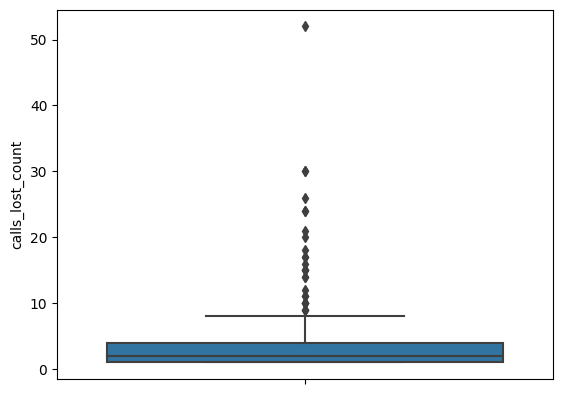

In [51]:
operators_ranking[operators_ranking['call_lost_cond']==True]

sns.boxplot(data=operators_ranking[(operators_ranking['call_lost_cond']==True)], y='calls_lost_count')

In [52]:
operators_ranking[(operators_ranking['call_lost_cond']==True)].describe()

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration,calls_wait_count,calls_wait_duration,calls_wait_total_duration,calls_wait_time,calls_out_count,calls_out_duration,calls_out_total_duration
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,198.000000,1.980000e+02,1.980000e+02
mean,921162.887029,3.874477,96.401674,169.907950,316.255230,31498.225941,35537.928870,4039.702929,1248.520202,7.467557e+04,1.003970e+05
std,20455.534602,5.943089,405.961280,451.435972,568.722797,53237.216239,58176.030527,6788.821036,6026.553703,3.863328e+05,5.268613e+05
min,882680.000000,1.000000,0.000000,1.000000,1.000000,38.000000,58.000000,8.000000,1.000000,0.000000e+00,0.000000e+00
25%,905202.000000,1.000000,0.000000,17.000000,29.000000,2751.000000,3230.000000,469.000000,53.000000,2.785250e+03,3.862500e+03
50%,920726.000000,2.000000,1.000000,43.000000,119.000000,12008.000000,14740.000000,1626.000000,226.000000,1.337700e+04,1.613900e+04
75%,937929.000000,4.000000,42.000000,111.500000,321.500000,32709.500000,36770.000000,4678.500000,813.250000,3.963975e+04,5.586075e+04
max,969272.000000,52.000000,4358.000000,4468.000000,4766.000000,397079.000000,402717.000000,40577.000000,58977.000000,4.304731e+06,5.664998e+06


In [53]:
# Actualizamos el campo "calls_lost_count" con los límites definidos
operators_ranking.loc[(operators_ranking['call_lost_cond']==True) & (operators_ranking['calls_lost_count']>4), 'call_lost_cond'] = True
operators_ranking.loc[(operators_ranking['call_lost_cond']==True) & (operators_ranking['calls_lost_count']<=4), 'call_lost_cond'] = False

#### Operadores con mayor tiempo de duración en llamadas en espera

<AxesSubplot:ylabel='calls_wait_time'>

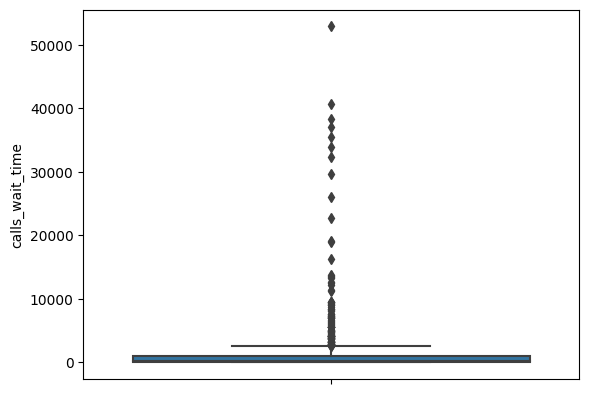

In [54]:
sns.boxplot(data=operators_ranking[(operators_ranking['call_wait_cond']==True)], y='calls_wait_time')

In [55]:
operators_ranking[(operators_ranking['call_wait_cond']==True)].describe()

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration,calls_wait_count,calls_wait_duration,calls_wait_total_duration,calls_wait_time,calls_out_count,calls_out_duration,calls_out_total_duration
count,754.000000,239.000000,239.000000,239.000000,754.000000,754.000000,754.000000,754.000000,544.000000,5.440000e+02,5.440000e+02
mean,923704.400531,3.874477,96.401674,169.907950,124.387268,12629.591512,14265.248011,1635.656499,633.082721,3.731376e+04,4.959800e+04
std,22646.733795,5.943089,405.961280,451.435972,356.449894,34048.558654,37503.815636,4637.607919,3693.139779,2.359110e+05,3.214051e+05
min,879896.000000,1.000000,0.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,0.000000e+00,0.000000e+00
25%,905153.000000,1.000000,0.000000,17.000000,4.000000,224.500000,311.500000,62.000000,15.000000,4.920000e+02,7.055000e+02
50%,924580.000000,2.000000,1.000000,43.000000,17.000000,1480.500000,1840.000000,255.000000,93.000000,5.791500e+03,7.172000e+03
75%,940457.500000,4.000000,42.000000,111.500000,78.750000,8097.750000,9019.000000,1064.250000,426.000000,2.501875e+04,3.220225e+04
max,973286.000000,52.000000,4358.000000,4468.000000,4766.000000,397079.000000,402717.000000,52875.000000,58977.000000,4.304731e+06,5.664998e+06


In [56]:
# Actualizamos el campo "call_wait_cond" con los límites definidos
operators_ranking.loc[(operators_ranking['call_wait_cond']==True) & (operators_ranking['calls_wait_time']>1000), 'call_wait_cond'] = True
operators_ranking.loc[(operators_ranking['call_wait_cond']==True) & (operators_ranking['calls_wait_time']<=1000), 'call_wait_cond'] = False

#### Operadores con menor cantidad de llamadas salientes realizadas

<AxesSubplot:ylabel='calls_out_count'>

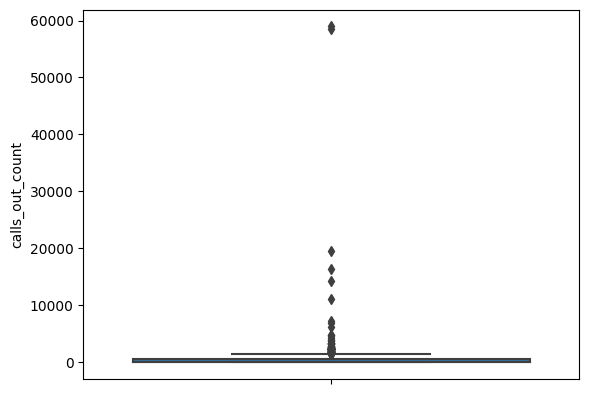

In [57]:
sns.boxplot(data=operators_ranking[(operators_ranking['call_out_cond']==True)], y='calls_out_count')

In [58]:
operators_ranking[(operators_ranking['call_out_cond']==True)].describe()

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration,calls_wait_count,calls_wait_duration,calls_wait_total_duration,calls_wait_time,calls_out_count,calls_out_duration,calls_out_total_duration
count,882.000000,198.000000,198.000000,198.000000,544.000000,544.000000,544.000000,544.000000,882.000000,8.820000e+02,8.820000e+02
mean,925658.340136,4.232323,115.813131,197.232323,160.827206,16162.128676,18238.112132,2075.983456,681.306122,3.676628e+04,4.999859e+04
std,22862.558731,6.377034,443.713781,491.606490,412.311299,39053.752799,43038.641505,5368.703807,3070.238896,1.890289e+05,2.579091e+05
min,879896.000000,1.000000,0.000000,2.000000,1.000000,1.000000,7.000000,2.000000,1.000000,0.000000e+00,0.000000e+00
25%,906394.500000,1.000000,0.000000,16.250000,5.000000,340.000000,421.000000,79.000000,11.000000,3.470000e+02,5.060000e+02
50%,924959.000000,2.000000,1.000000,51.000000,24.000000,2253.500000,2645.500000,324.500000,90.000000,5.773500e+03,7.289000e+03
75%,943630.000000,4.000000,59.750000,150.750000,122.500000,13659.750000,15728.250000,1569.000000,597.250000,3.134400e+04,4.595925e+04
max,973120.000000,52.000000,4358.000000,4468.000000,4766.000000,397079.000000,402717.000000,52875.000000,58977.000000,4.304731e+06,5.664998e+06


In [59]:
# Actualizamos el campo "call_out_cond" con los límites definidos
operators_ranking.loc[(operators_ranking['call_out_cond']) & (operators_ranking['calls_out_count']<=100), 'call_out_cond'] = True
operators_ranking.loc[(operators_ranking['call_out_cond']) & (operators_ranking['calls_out_count']>100), 'call_out_cond'] = False

### Clasificamos a los operadores ineficaces

In [60]:
# Creamos dos campos: "status", "prioridad"

operators_ranking[['tipo_operador', 'prioridad']] = ''

In [61]:
# Operadores que cumplen con las 3 condiciones de operadores ineficaces
operators_ranking[(operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==True)]['operator_id'].unique()

array([906410, 905862, 919554, 919166, 919206, 919204, 937956, 940588])

In [62]:
operators_ranking.loc[(operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==True), 'tipo_operador'] = 'ineficaz'
operators_ranking.loc[(operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==True), 'prioridad'] = 'alta'

In [63]:
# Operadores que cumplen con al menos 2 condiciones de operadores ineficaces
operators_ranking[(operators_ranking['tipo_operador']=='')&
                  (((operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==False))|
                   ((operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==False)&(operators_ranking['call_out_cond']==True))|
                   ((operators_ranking['call_lost_cond']==False)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==True))
                  )]

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration,calls_wait_count,calls_wait_duration,calls_wait_total_duration,calls_wait_time,calls_out_count,calls_out_duration,calls_out_total_duration,call_lost_cond,call_wait_cond,call_out_cond,tipo_operador,prioridad
12,882686,6.0,2.0,73.0,766.0,143970.0,155241.0,11271.0,2884.0,222447.0,275859.0,True,True,False,,
79,900194,2.0,0.0,87.0,55.0,10643.0,11822.0,1179.0,43.0,4780.0,6147.0,False,True,True,,
83,908960,14.0,111.0,515.0,695.0,66211.0,82475.0,16264.0,113.0,7433.0,8523.0,True,True,False,,
87,885890,26.0,5.0,266.0,1244.0,79487.0,90793.0,11306.0,58977.0,3261303.0,4692999.0,True,True,False,,
88,885876,20.0,5.0,240.0,992.0,59222.0,68239.0,9017.0,58437.0,4304731.0,5664998.0,True,True,False,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,940658,10.0,903.0,965.0,862.0,73000.0,77181.0,4181.0,1726.0,57560.0,85352.0,True,True,False,,
988,940652,9.0,1011.0,1042.0,414.0,22185.0,23902.0,1717.0,860.0,38514.0,57533.0,True,True,False,,
990,940622,16.0,2415.0,2502.0,677.0,35972.0,39031.0,3059.0,718.0,27097.0,42059.0,True,True,False,,
1001,952948,8.0,0.0,9.0,3542.0,397079.0,402717.0,5638.0,1178.0,74351.0,90283.0,True,True,False,,


In [64]:
operators_ranking.loc[(operators_ranking['tipo_operador']=='')&
                  (((operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==False))|
                   ((operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==False)&(operators_ranking['call_out_cond']==True))|
                   ((operators_ranking['call_lost_cond']==False)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==True))
                  ), 'tipo_operador'] = 'ineficaz'
operators_ranking.loc[(operators_ranking['prioridad']=='')&
                  (((operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==False))|
                   ((operators_ranking['call_lost_cond']==True)&(operators_ranking['call_wait_cond']==False)&(operators_ranking['call_out_cond']==True))|
                   ((operators_ranking['call_lost_cond']==False)&(operators_ranking['call_wait_cond']==True)&(operators_ranking['call_out_cond']==True))
                  ), 'prioridad'] = 'media'

In [65]:
# Operadores que cumplen con al menos 1 condicion de operador ineficaz
operators_ranking[(operators_ranking['tipo_operador']=='')&((operators_ranking['call_lost_cond']==True)|(operators_ranking['call_wait_cond']==True)|(operators_ranking['call_out_cond']==True))]

,operator_id,calls_lost_count,call_lost_duration,call_lost_total_duration,calls_wait_count,calls_wait_duration,calls_wait_total_duration,calls_wait_time,calls_out_count,calls_out_duration,calls_out_total_duration,call_lost_cond,call_wait_cond,call_out_cond,tipo_operador,prioridad
1,880020,NaN,NaN,NaN,7.0,299.0,353.0,54.0,38.0,1946.0,2172.0,False,False,True,,
2,881278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,465.0,543.0,False,False,True,,
6,882478,NaN,NaN,NaN,3.0,68.0,144.0,76.0,1.0,0.0,7.0,False,False,True,,
8,891900,NaN,NaN,NaN,33.0,3987.0,5227.0,1240.0,NaN,NaN,NaN,False,True,False,,
9,891906,NaN,NaN,NaN,67.0,12593.0,14375.0,1782.0,NaN,NaN,NaN,False,True,False,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,959596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,199.0,258.0,False,False,True,,
1078,952196,NaN,NaN,NaN,2.0,84.0,108.0,24.0,2.0,6.0,42.0,False,False,True,,
1089,952916,NaN,NaN,NaN,1.0,161.0,186.0,25.0,7.0,346.0,521.0,False,False,True,,
1090,959118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,905.0,1187.0,False,False,True,,


In [66]:
operators_ranking.loc[(operators_ranking['tipo_operador']=='')&((operators_ranking['call_lost_cond']==True)|(operators_ranking['call_wait_cond']==True)|(operators_ranking['call_out_cond']==True)),'tipo_operador'] = 'ineficaz'
operators_ranking.loc[(operators_ranking['prioridad']=='')&((operators_ranking['call_lost_cond']==True)|(operators_ranking['call_wait_cond']==True)|(operators_ranking['call_out_cond']==True)),'prioridad'] = 'baja'

In [67]:
# Operadores eficaces
operators_ranking[(operators_ranking['tipo_operador']=='')&(operators_ranking['call_lost_cond']==False)&(operators_ranking['call_wait_cond']==False)&(operators_ranking['call_out_cond']==False)].count()

operator_id                  479
calls_lost_count              54
call_lost_duration            54
call_lost_total_duration      54
calls_wait_count             316
calls_wait_duration          316
calls_wait_total_duration    316
calls_wait_time              316
calls_out_count              297
calls_out_duration           297
calls_out_total_duration     297
call_lost_cond               479
call_wait_cond               479
call_out_cond                479
tipo_operador                479
prioridad                    479
dtype: int64

In [68]:
operators_ranking.loc[(operators_ranking['tipo_operador']=='')&(operators_ranking['call_lost_cond']==False)&(operators_ranking['call_wait_cond']==False)&(operators_ranking['call_out_cond']==False),'tipo_operador'] = 'eficaz'

In [69]:
operators_ranking.groupby('tipo_operador')['tipo_operador'].count()

tipo_operador
eficaz      479
ineficaz    613
Name: tipo_operador, dtype: int64

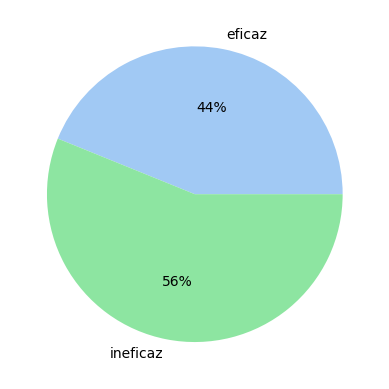

In [70]:
data = [479, 613]
labels = ["eficaz", "ineficaz"]
colors = sns.color_palette("pastel6")
plt.pie(data, labels=labels, colors=colors, autopct="%0.0f%%")
plt.show()

In [71]:
operators_ranking[operators_ranking['tipo_operador']=='ineficaz'].groupby('prioridad')['prioridad'].count()

prioridad
alta       8
baja     540
media     65
Name: prioridad, dtype: int64

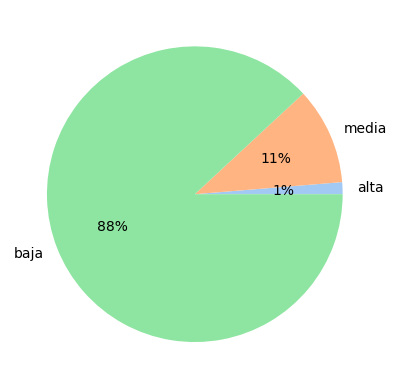

In [72]:
data = [8, 65, 540]
labels = ["alta", "media", "baja"]
colors = sns.color_palette("pastel")
plt.pie(data, labels=labels, colors=colors, autopct="%0.0f%%")
plt.show()

In [73]:
# Exportamos los dataframes validados para generar un dashboard
operators_ranking.to_csv('operators_ranking.csv', index=False)
calls.to_csv('calls.csv', index=False)
clients.to_csv('clients.csv', index=False)

En esta sección se definió la lógica para identificar a los operadores ineficaces, donde se concluye lo siguiente:
* La muestra nos indica que se cuenta con 1,092 operadores que atendieron llamadas.
* El 44% de operadores son eficaces (479) y el 56% son operadores ineficaces (613).
* De los 613 operadores ineficaces se establecieron prioridades donde:
    * 8 (1%) se encuentran en prioridad alta (cumplieron con las 3 condiciones que caracterizan a un operador ineficaz)
    * 65 (11%) se encuentran en prioridad media (cumplieron con al menos 2 condiciones que caracterizan a un operador ineficaz)
    * 540 (88%) se encuentran en prioridad baja (cumplieron con al menos 1 condición que caracteriza a un operador ineficaz)

[Volver a la Tabla de Contenido](#indice)

<a id="prueba_hipotesis"></a>
## Prueba de hipótesis estadística

### La cantidad de llamadas de los operadores ineficaces es menor a la cantidad de llamadas en operadores eficaces

Definimos las hipótesis:
- H0: La cantidad de llamadas de los operadores ineficaces es menor a la cantidad de llamadas de los operadores eficaces.
- H1: La cantidad de llamadas de los operadores ineficaces es mayor a la cantidad de llamadas de los operadores eficaces.

Además, para la prueba consideraremos el umbral de alpha en 0.05.

In [74]:
# Creamos los dataframes para ralizar la prueba de hipótesis
df_ineficaces = calls[calls['operator_id'].isin(operators_ranking[operators_ranking['tipo_operador']=='ineficaz']['operator_id'].unique())==True].groupby('operator_id')['calls_count'].sum().reset_index()
df_eficaces = calls[calls['operator_id'].isin(operators_ranking[operators_ranking['tipo_operador']=='eficaz']['operator_id'].unique())==True].groupby('operator_id')['calls_count'].sum().reset_index()

In [75]:
# Validamos si las varianzas son iguales o no, usando la función de levene
st.levene(df_eficaces['calls_count'], df_ineficaces['calls_count'])

LeveneResult(statistic=0.2610092392052429, pvalue=0.6095310973720172)

La función de levene indica una significancia de 0.6095, el cual al ser mucho mayor que el umbral del alpha (0.05) lo que nos indica que las varianzas son iguales.

In [76]:
#Realizamos la prueba de hipótesis

#umbral de alpha
alpha = 0.05

#usamos la función ttest_ind para probar la hipótesis
results = st.ttest_ind(df_eficaces['calls_count'], df_ineficaces['calls_count'], equal_var = True)

print()
print('valor p:', results.pvalue)
print()

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula.")


valor p: 0.46874705212666934

No podemos rechazar la hipótesis nula.


Para esta evaluación el resultado indica que debemos aceptar la hipótesis nula; lo que significa que la cantidad de llamadas de los operadores ineficaces es menor a la cantidad de llamadas de los operadores eficaces.

### La duración de llamadas de los operadores ineficaces es menor a la duración de llamadas de operadores eficaces

Definimos las hipótesis:
- H0: La duración de llamadas de los operadores ineficaces es menor a la duración de llamadas de operadores eficaces.
- H1: La duración de llamadas de los operadores ineficaces es mayor a la duración de llamadas de operadores eficaces

Además, para la prueba consideraremos el umbral de alpha en 0.05.

In [77]:
# Creamos los dataframes para ralizar la prueba de hipótesis
df_ineficaces = calls[calls['operator_id'].isin(operators_ranking[operators_ranking['tipo_operador']=='ineficaz']['operator_id'].unique())==True].groupby('operator_id')['call_duration'].sum().reset_index()
df_eficaces = calls[calls['operator_id'].isin(operators_ranking[operators_ranking['tipo_operador']=='eficaz']['operator_id'].unique())==True].groupby('operator_id')['call_duration'].sum().reset_index()

In [78]:
# Validamos si las varianzas son iguales o no, usando la función de levene
st.levene(df_eficaces['call_duration'], df_ineficaces['call_duration'])

LeveneResult(statistic=0.3687462960227355, pvalue=0.5438149120113792)

La función de levene indica una significancia de 0.5438, el cual al ser mucho mayor que el umbral del alpha (0.05) lo que nos indica que las varianzas son iguales.

In [79]:
#Realizamos la prueba de hipótesis

#umbral de alpha
alpha = 0.05

#usamos la función ttest_ind para probar la hipótesis
results = st.ttest_ind(df_eficaces['call_duration'], df_ineficaces['call_duration'], equal_var = True)

print()
print('valor p:', results.pvalue)
print()

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula.")


valor p: 0.7044162661148028

No podemos rechazar la hipótesis nula.


Para esta evaluación el resultado indica que debemos aceptar la hipótesis nula; lo que significa que la duración de llamadas de los operadores ineficaces es menor a la duración de llamadas de operadores eficaces.

[Volver a la Tabla de Contenido](#indice)

<a id="conclusiones"></a>
## Conclusiones y recomendaciones

### Conclusiones

* La muestra indica que se tienen 732 clientes.
* La cantidad de clientes desde el 01/08/2019 hasta el 31/10/2019 ha sido constante, salvo algunos días.
* La muestra indica que se tienen 1,092 operadores que atienden a los 732 clientes.
* El número de operadores en promedio que atiende a cada usuario es 4.
* Un operador solo atiende a un usuario.
* Los usuarios tienen entre 1 y 10 operadores atendiendo sus llamadas; sin embargo, hay algunos usuarios que pueden tener hasta 50 operadores.
* La muestra indica que se tienen 3 tipos de tarifa: A, B, C. Donde asumiremos que el plan más caro es A, seguido de B y finalmente C (plan más barato).
* La mayor cantidad de usuarios se encuentra entre el plan B y C; y unos pocos en el plan A.
* El número de operadores por tipo de plan asignado es equitativo.
* El número de llamadas realizadas por tipo de tarifa es mayor en el plan A y eso debe explicar porque la duración total de las llamadas en el plan A también es el más alto.
* La muestra indica que sí existe correlación directa, a mayor cantidad de operadores mayor cantidad de llamadas.
* La muestra indica que la cantidad de llamadas fueron incrementando constantemente, llegando a ser estables a partir de mediados de setiembre.
* La muestra indica que se realizaron 694,714 llamadas, de las cuales:
    * El 86% corresponde a llamadas salientes mientras que el 14% corresponde a llamadas entrantes.
    * El 98% corresponde a llamadas externas y solo el 2% corresponde a llamadas internas.
    * El 62% corresponde a llamadas contestadas mientras que el 38% corresponde a llamadas pérdidas.

* De la identificación de operadores entre eficaces e ineficaces se encontro lo siguiente:
    * El 44% de operadores son eficaces (479) y el 56% son operadores ineficaces (613).
    * De los 613 operadores ineficaces se establecieron prioridades donde:
        * 8 (1%) se encuentran en prioridad alta (cumplieron con las 3 condiciones que caracterizan a un operador ineficaz)
        * 65 (11%) se encuentran en prioridad media (cumplieron con al menos 2 condiciones que caracterizan a un operador ineficaz)
        * 540 (88%) se encuentran en prioridad baja (cumplieron con al menos 1 condición que caracteriza a un operador ineficaz)

### Recomendaciones

* Se sugiere crear un dashboard que contenga los principales KPI's:
    * Cantidad de llamadas    
    * Cantidad de operadores que en promedio atiende a cada usuario
    * Cantidad promedio de llamadas que atiende un operador
    * Duración promedio de llamadas que atiende un operador
    * Lista de operadores ineficaces indicando el nivel de prioridad
* Se sugiere que se publique mensualmente.

[Volver a la Tabla de Contenido](#indice)

<a id="presentacion"></a>
## Presentación

<a href="https://drive.google.com/file/d/1V-TBVr3vV-P5dbj6VkYl2qevovx1wjFi/view?usp=sharing">Ver presentación</a>

[Volver a la Tabla de Contenido](#indice)